In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/fOskhV3t-k8" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

# **Step 1: Clone Repo and install all dependencies**

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt
%cd yolov5

import torch
from IPython.display import Image, clear_output
from utils.google_utils import gdrive_download

clear_output()

# **Step 2: Download the custom data-set that you are interested in (using the Roboflow api)**  [Link to datasets](https://public.roboflow.com/)

In [ ]:
%cd /content
!curl -L "PASTE YOUR LINK HERE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1347      0 --:--:-- --:--:-- --:--:--  1347
100 3791k  100 3791k    0     0  4347k      0 --:--:-- --:--:-- --:--:-- 4347k
Archive:  roboflow.zip
 extracting: test/images/w1240-p16x9-0e48e0098f6e832f27d8b581b33bbc72b9967a63_jpg.rf.34ed1e8f70eebdabaf43ab9d40dc1c9b.jpg  
 extracting: test/images/RTX7CCFN_jpg.rf.66ed5c5054f30d933d19ab3d56ace004.jpg  
 extracting: test/images/the-first-day-of-wuhan-s-closure-some-people-fled-some-panicked_jpg.rf.0302fefb0879eb37736a704ca5d070ff.jpg  
 extracting: test/images/1288126-10255706714jpg_jpg.rf.95f7324cbfd48e0386e0660b5e932223.jpg  
 extracting: test/images/126202-untitled-design-13_jpg.rf.56b50d413464989bb2232448a8fbb915.jpg  
 extracting: test/images/r1p00017o8171pnq407_jpg.rf.6fd25b7219a249e97f54fcabf2b52726.jpg  
 extracting: test/images/w1240-

# **Step 3: Create the custom model configuration file**

In [ ]:
#extracting information from the roboflow file
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['mask', 'no-mask']

In [ ]:
# define number of classes based on data.yaml
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# **Step 4: Train yolov5 on the custom images using the custom configuration file**

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-99-g3f74cd9 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-05-18 08:26:36.439366: I tensorflow/stream_executor/platfo

#**Step 5: Run yolov5 detection on images.**
# *Don't forget to copy the location of the weights file and replace it in the code below*

In [ ]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 🚀 v5.0-99-g3f74cd9 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.8 GFLOPS
image 1/15 /content/yolov5/../test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.3135dfc5feab288d76a4ccfd22dfc5bf.jpg: 416x416 1 mask, Done. (0.014s)
image 2/15 /content/yolov5/../test/images/1224331650_g_400-w_g_jpg.rf.b816f49e2d84044fc997a8cbd55c347d.jpg: 416x416 Done. (0.008s)
image 3/15 /content/yolov5/../test/images/126202-untitled-design-13_jpg.rf.56b50d413464989bb2232448a8fbb915.jpg: 416x416 5 masks, Do

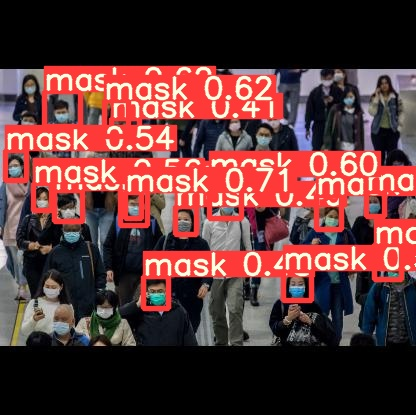

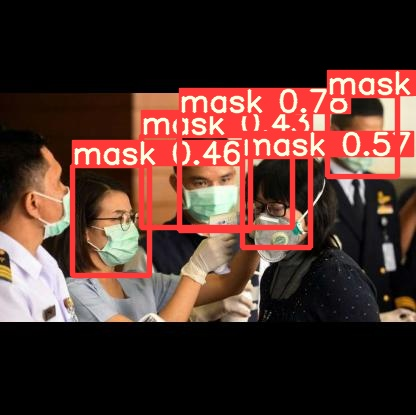

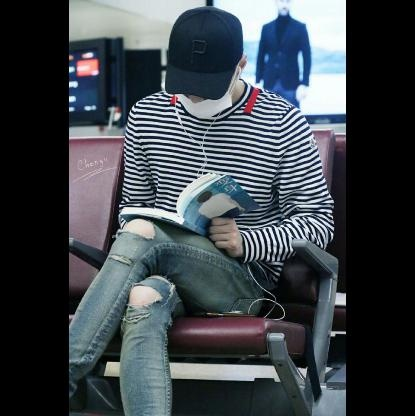

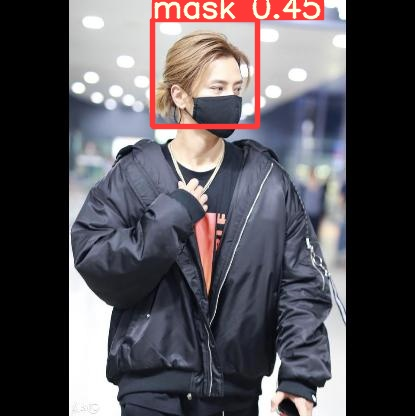

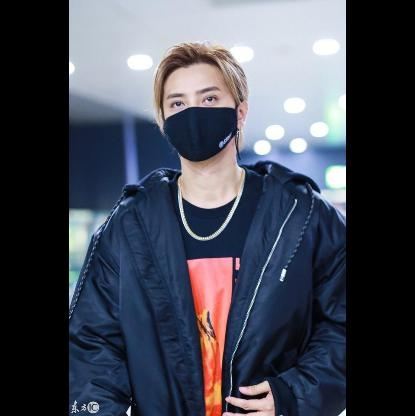

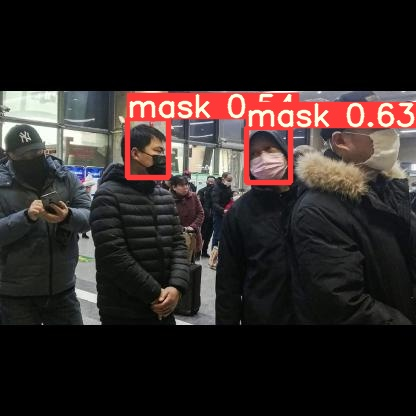

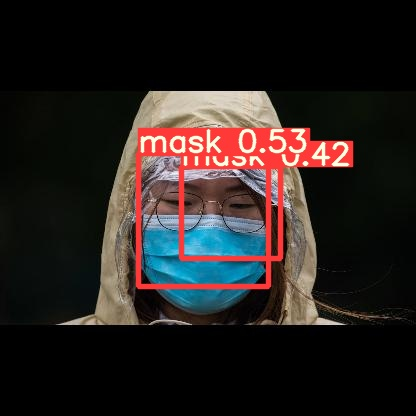

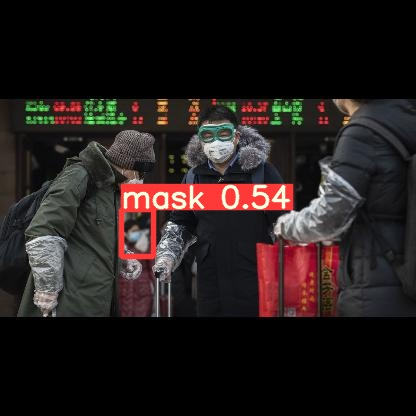

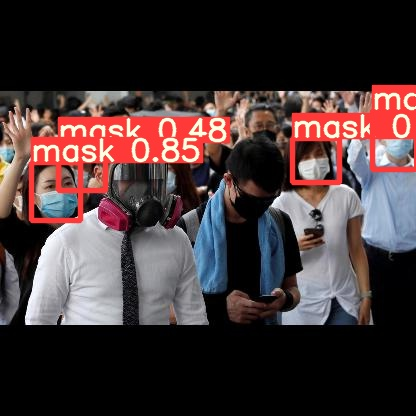

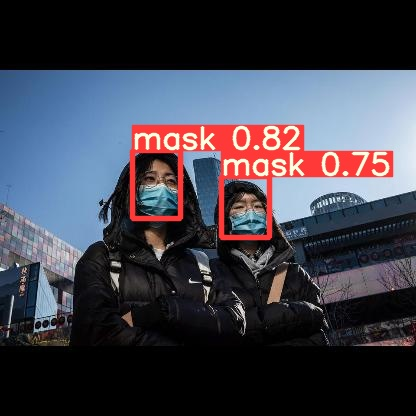

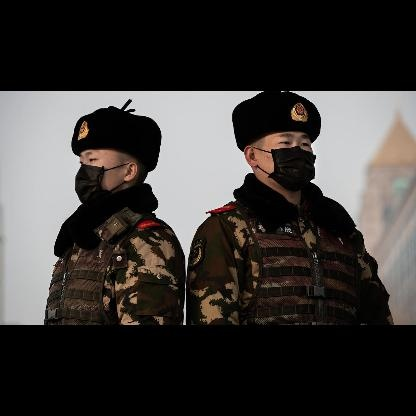

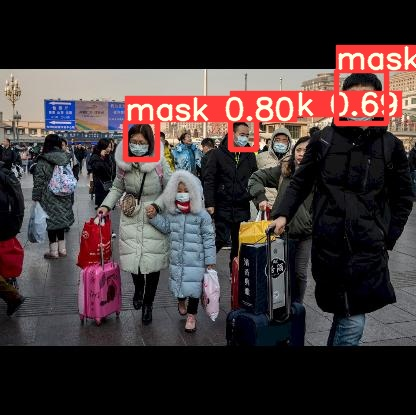

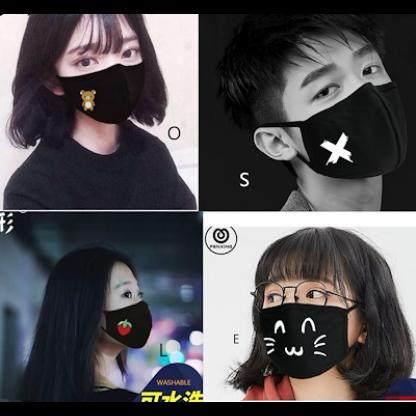

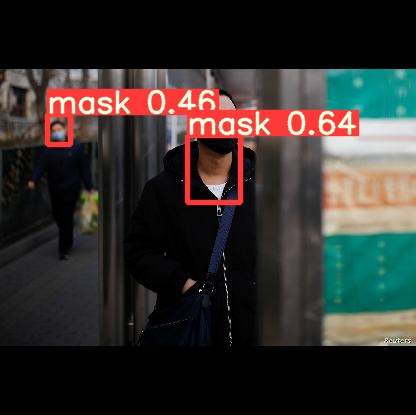

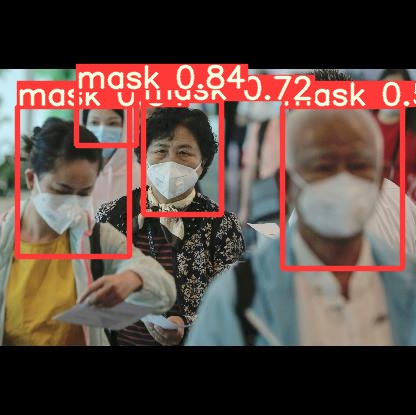

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'):
    display(Image(filename=imageName))
    print("\n")